# Лабораторная работа №10. ОСНОВЫ ОБРАБОТКИ ЕСТЕСТВЕННОГО ЯЗЫКА (NLP). ЗАДАЧА ТЕМАТИЧЕСКОГО МОДЕЛИРОВАНИЯ

**ЗАДАНИЕ**
1. Для выполнения задания используйте датасет с данными о спаме (https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset).
2. *Самостоятельно реализовать BoW, TF-IDF.
3. Решить задачу классификации с понижением размерности. \
*Использовать самостоятельно реализованные модели из предыдущих ЛР.
4. Решить задачу тематического моделирования с помощью LDA.

## Preprocessing 

### Загрузка и обзор данных

In [1]:
import pandas as pd


df = pd.read_csv('C:/Users/seito/Jupyter Notebook/data/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  7 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Удалим лишние столбцы и переименуем оставшиеся

In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.columns = ["Label", "Message"]

df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Удалим дубликаты

In [4]:
df.duplicated().sum()

403

In [5]:
df = df.drop_duplicates().reset_index(drop=True)

In [6]:
df.duplicated().sum()

0

### Избавимся от дисбаланса классов

C:\Users\seito\AppData\Local\Temp\ipykernel_9936\2622264459.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Label', palette='magma')


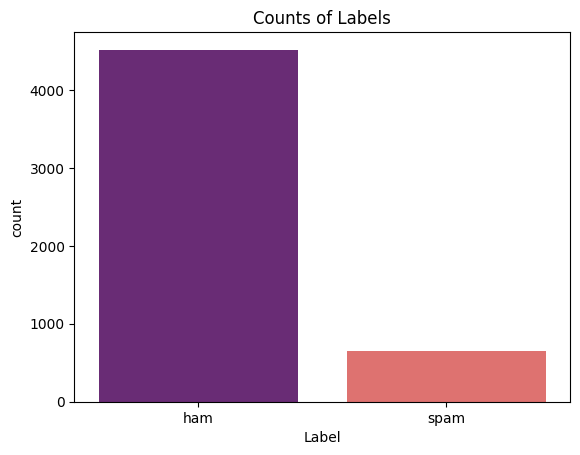

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.countplot(data=df, x='Label', palette='magma')
plt.title("Counts of Labels")
plt.show()

In [8]:
df.Label.value_counts()

ham     4516
spam     653
Name: Label, dtype: int64

In [9]:
spam = df[df['Label'] == 'spam']
ham = df[df['Label'] == 'ham'].sample(spam.shape[0])

df = pd.concat([spam, ham], axis=0).sample(frac=1).reset_index(drop=True)
df.head()

,Label,Message
0,ham,Except theres a chick with huge boobs.
1,ham,I had been hoping i would not have to send you...
2,spam,PRIVATE! Your 2003 Account Statement for 07808...
3,spam,Here is your discount code RP176781. To stop f...
4,spam,U have a secret admirer. REVEAL who thinks U R...


### Лемматизация, удаление стоп-слов и пунктуации

In [10]:
import re
import string
import spacy

nlp = spacy.load("en_core_web_sm")


def del_punct(text):
    chars = []
    for char in text:
        if char not in string.punctuation.replace("'", ''):
            chars.append(char)
        else:
            chars.append(' ')
    return ''.join(chars)

def text_preparation(text: str) -> str:
    text = text.lower()
    text = del_punct(text)
    doc = nlp(text)
    text = ' '.join([
            token.lemma_ 
                for token in doc 
                if token.text not in nlp.Defaults.stop_words and len(token.text)>1
        ])
    
    text = re.sub(r'\d+', ' somenumbers ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text
     
def preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Length'] = df['Message'].apply(len)
    df['Message'] = df['Message'].apply(text_preparation)
    return df

df = preprocessing(df)

In [11]:
text_preparation("Todays Voda numbers,,  ending 1225 are selected to receive a å£50award. ")

'today voda number end somenumbers select receive somenumbers award'

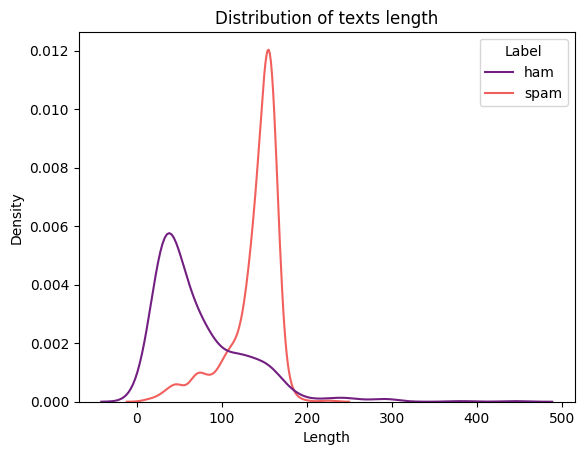

In [12]:
sns.kdeplot(data=df, x='Length', hue='Label',  palette='magma')
plt.title("Distribution of texts length")
plt.show()

Как видно из графика условных распределений, спам-сообщения длиннее, чем обычные.

In [13]:
df.sample(5)

,Label,Message,Length
1093,spam,england official poly ringtone colour flag yer...,157
681,ham,hmmm thk sure get time hop ard ya free abt muz...,94
779,ham,sir wait,32
1107,ham,hang brother family,42
793,spam,phony somenumbers award today voda number end ...,179


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306 entries, 0 to 1305
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    1306 non-null   object
 1   Message  1306 non-null   object
 2   Length   1306 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 30.7+ KB


## Bag of Words (BoW) и Term Frequency Inverse Document Frequency (TF-IDF)

In [15]:
from sklearn.preprocessing import LabelEncoder

df.reset_index(drop=True, inplace=True)
X = df['Message']
y = LabelEncoder().fit_transform(df['Label'])
# 1 - 'spam'
# 2 - 'pam'

y

array([0, 0, 1, ..., 0, 1, 1])

### Векторизация с помощью BoW

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(ngram_range=(1,2), min_df=2)
X_bow = bow.fit_transform(X).toarray()
print(X_bow.shape)
bow.vocabulary_

(1306, 2973)


{'hope': 932,
 'send': 1926,
 'message': 1260,
 'rent': 1804,
 'not': 1471,
 'completely': 362,
 'go': 806,
 'loan': 1157,
 'need': 1415,
 'balance': 123,
 'lt': 1203,
 'gt': 839,
 'way': 2795,
 'till': 2515,
 'mid': 1269,
 'march': 1229,
 'pay': 1568,
 'send message': 1933,
 'lt gt': 1205,
 'private': 1696,
 'somenumbers': 2029,
 'account': 10,
 'statement': 2347,
 'show': 1974,
 'un': 2650,
 'redeem': 1783,
 'point': 1645,
 'identifier': 972,
 'code': 321,
 'expire': 636,
 'private somenumbers': 1697,
 'somenumbers account': 2030,
 'account statement': 11,
 'statement somenumbers': 2349,
 'somenumbers show': 2209,
 'show somenumbers': 1975,
 'somenumbers un': 2245,
 'un redeem': 2651,
 'redeem point': 1784,
 'point somenumbers': 1647,
 'somenumbers identifier': 2111,
 'identifier code': 973,
 'code somenumbers': 322,
 'somenumbers expire': 2086,
 'expire somenumbers': 637,
 'somenumbers somenumbers': 2213,
 'discount': 530,
 'stop': 2359,
 'reply': 1813,
 'www': 2899,
 'co': 318,
 'u

### Векторизация с помощью TF-IDF

$tfidf=(1+\log{tf})∗idf$

$idf=\log\frac{(N+1)}{(Nw+1)}+1$

Здесь tf это частота слова в тексте (то же самое, что в bag of words), N - общее число документов, Nw - число документов, содержащих данное слово.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(sublinear_tf=True) # с сублинейным масштабированием

X_tfidf = tf_vectorizer.fit_transform(df['Message']).toarray()
print(X_tfidf.shape)
tf_vectorizer.vocabulary_

(1306, 3046)


{'chick': 411,
 'huge': 1177,
 'boob': 273,
 'hope': 1151,
 'send': 2280,
 'message': 1582,
 'rent': 2151,
 'not': 1756,
 'reserve': 2164,
 'completely': 491,
 'go': 1018,
 'loan': 1447,
 'need': 1717,
 'balance': 185,
 'lt': 1486,
 'gt': 1064,
 'way': 2870,
 'till': 2640,
 'mid': 1587,
 'march': 1526,
 'pay': 1874,
 'private': 2009,
 'somenumbers': 2392,
 'account': 19,
 'statement': 2449,
 'show': 2321,
 'un': 2748,
 'redeem': 2123,
 'point': 1946,
 'identifier': 1201,
 'code': 461,
 'expire': 819,
 'discount': 664,
 'rp': 2206,
 'stop': 2467,
 'reply': 2157,
 'www': 2982,
 'regalportfolio': 2132,
 'co': 456,
 'uk': 2743,
 'customer': 578,
 'service': 2288,
 'secret': 2268,
 'admirer': 38,
 'reveal': 2176,
 'think': 2622,
 'special': 2416,
 'opt': 1817,
 'msg': 1668,
 'recd': 2108,
 'cust': 575,
 'care': 352,
 'mobile': 1625,
 'number': 1771,
 'win': 2917,
 'claim': 431,
 'call': 331,
 'ring': 2185,
 'hot': 1158,
 'line': 1424,
 'good': 1029,
 'afternoon': 54,
 'sunshine': 2519,
 'da

## Решение задачи классификации

### Понижение размерности

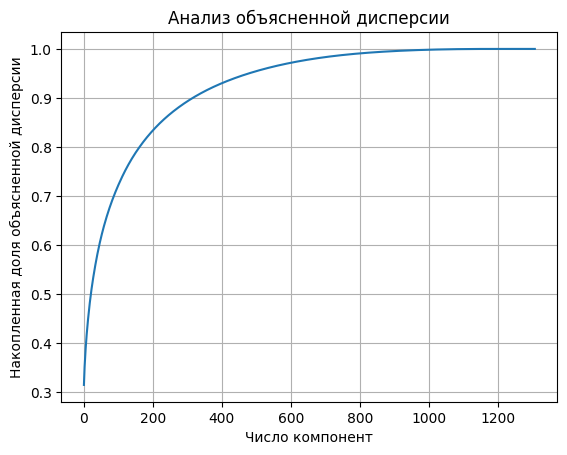

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Создаем экземпляр PCA
pca = PCA()

# Обучаем PCA на данный X
pca.fit(X_bow)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Визуализация объясненной дисперсии
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel("Число компонент")
plt.ylabel("Накопленная доля объясненной дисперсии")
plt.title("Анализ объясненной дисперсии")
plt.grid(True)
plt.show()

In [19]:
pca1 = PCA(n_components=300)

X_bow_pca = pca1.fit_transform(X_bow, y)
sum(pca1.explained_variance_ratio_)

0.8914120018457549

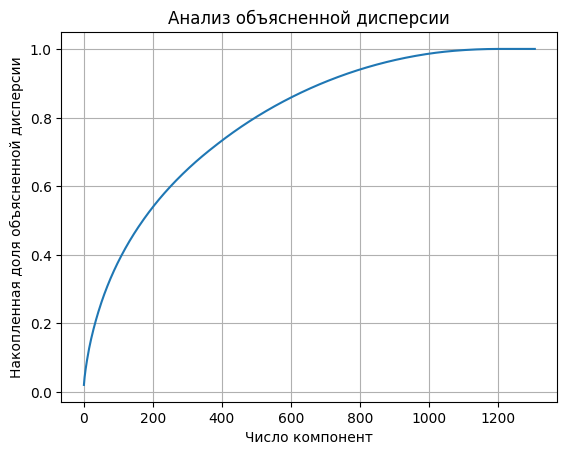

In [20]:
# Создаем экземпляр PCA
pca = PCA()

# Обучаем PCA на данный X
pca.fit(X_tfidf)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Визуализация объясненной дисперсии
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel("Число компонент")
plt.ylabel("Накопленная доля объясненной дисперсии")
plt.title("Анализ объясненной дисперсии")
plt.grid(True)
plt.show()

In [21]:
pca2 = PCA(n_components=500)

X_tfidf_pca = pca2.fit_transform(X_tfidf, y)
sum(pca2.explained_variance_ratio_)

0.7967167564514571

### Обучение и оценка моделей

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

models = [
    KNeighborsClassifier(n_neighbors=5),
    LogisticRegression(solver="liblinear"),
    RandomForestClassifier(max_depth=10)
]

def test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    for model in models:
        mdl = model.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
        print(f'Results for {type(model).__name__}: \n')
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        print('Accuracy: ', accuracy_score(y_test, y_pred))
        print()

In [23]:
test(X_bow_pca, y)

c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\seito\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Results for KNeighborsClassifier: 

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       121
           1       1.00      0.84      0.91       141

    accuracy                           0.91       262
   macro avg       0.92      0.92      0.91       262
weighted avg       0.93      0.91      0.91       262

[[121   0]
 [ 23 118]]
Accuracy:  0.9122137404580153

Results for LogisticRegression: 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       121
           1       1.00      0.95      0.97       141

    accuracy                           0.97       262
   macro avg       0.97      0.98      0.97       262
weighted avg       0.97      0.97      0.97       262

[[121   0]
 [  7 134]]
Accuracy:  0.9732824427480916

Results for RandomForestClassifier: 

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       121
           1       0.

In [24]:
test(X_tfidf_pca, y)

Results for KNeighborsClassifier: 

              precision    recall  f1-score   support

           0       0.58      1.00      0.74       121
           1       1.00      0.39      0.56       141

    accuracy                           0.67       262
   macro avg       0.79      0.70      0.65       262
weighted avg       0.81      0.67      0.64       262

[[121   0]
 [ 86  55]]
Accuracy:  0.6717557251908397

Results for LogisticRegression: 

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       121
           1       1.00      0.91      0.96       141

    accuracy                           0.95       262
   macro avg       0.95      0.96      0.95       262
weighted avg       0.96      0.95      0.95       262

[[121   0]
 [ 12 129]]
Accuracy:  0.9541984732824428

Results for RandomForestClassifier: 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       121
           1       0.

## Решение задачи тематического моделирования с помощью LDA

Латентное размещение Дирихле (LDA) — это вероятностная модель, разработанная для моделирования тем в коллекциях документов. Она основана на предположении, что каждый документ может быть представлен как смесь различных тем, а каждая тема связана с распределением слов.

Шаг 1: Инициализация параметров. \
    Задается количество тем (гиперпараметр K) и другие параметры модели.

Шаг 2: Подготовка данных. \
Документы преобразуются в числовое представление, например, с помощью "мешка слов" или TF-IDF матриц.

Шаг 3: Инициализация распределений. \
Инициализируются распределения тем для документов и распределения слов для тем.

Шаг 4: Итеративный процесс.\
Повторяется следующий процесс для нескольких итераций:
- Для каждого слова в каждом документе вычисляется вероятность принадлежности к каждой теме, используя текущие распределения тем и слов.
- На основе вероятностей слов в темах и вероятностей тем в документах пересчитываются распределения тем и слов.

Шаг 5: Вывод результатов.\
По окончании итераций можно получить распределения тем для каждого документа и распределения слов для каждой темы.

In [30]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=1000,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(df['Message'])

In [31]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=20,
    learning_method='online',
    learning_offset=50.,
    random_state=0
).fit(tf)

In [32]:
lda.transform(tf).shape

(1306, 10)

In [38]:
feature_names = tf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
        print("Topic #%d:" % (topic_idx+1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

Topic #1:
like ok work home time lor today wait pick wat
Topic #2:
ok think ya dear need special look good ur pc
Topic #3:
reply end game ur question ac new sms wap ans
Topic #4:
somenumbers free txt text stop ur reply mobile min www
Topic #5:
gt lt night good hope problem th life want hi
Topic #6:
know let day need great work pls time help wish
Topic #7:
somenumbers claim prize win contact cash urgent award ppm box
Topic #8:
thing tell later money pa normal month probably start bed
Topic #9:
come sorry love miss want tell talk oh babe da
Topic #10:
happen hey yup lose try gym study hospital long intro
